## Questions to answer

Analyzing the top 100 ETF based on Assets under management (AUM)

1. Analysis on Return to volaltility
2. Cluster etfs to based on similarity
3. Calculate alpha and beta of stock compared to spy


"https://markets.ft.com/data/etfs/tearsheet/risk?s=XLF:PCQ:USD"

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gmean
from sklearn.linear_model import LinearRegression
from datetime import date
from datetime import timedelta
from selenium.webdriver.chrome.webdriver import WebDriver
from bs4 import BeautifulSoup
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')
from yahoo_historical import Fetcher
import plotly_express as px

### Define Functions to fetch data

In [2]:
def data_fetcher(etflist, start, end):
    """
    Takes in a list of etf symbols 
    returns pandas dataframe of price details and dividends
    """
    price_df = pd.DataFrame()
    dividend = pd.DataFrame()
    for e in etflist:
        data = Fetcher(e, start, end)
        pricedata = data.getHistorical()
        if 'Date' in data.getHistorical().columns.tolist():
            pricedata['ticker'] = e
            price_df = price_df.append(pricedata)
            divddata = data.getDividends()
            divddata['ticker'] = e
            dividend = dividend.append(divddata)
    return price_df, dividend

In [3]:
def daily_returns(df):
    return df.pct_change().fillna(0)

def cum_return(df):
    return mydf/mydf.iloc[0, :]#.plot(kind='line', ax=ax)
    
#def georeturns(df)
    
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')

### Load data

In [4]:
# Load etf_tickers
etf_tickers = pd.read_csv('Data/ETF_top_100/ETF_top_100_aum.csv', encoding = "ISO-8859-1")
etf_tickers['Symbol'] = etf_tickers['Symbol'].str.rstrip()
etf_tickers['AUM'] = etf_tickers['AUM'].str.replace(r',|\.|\$', '').astype('int64')*10
etf_tickers.tail()

,Symbol,Name,AUM,Avg Volume
95,FDN,First Trust Dow Jones Internet Index,9177427870,"415,830"
96,BIL,SPDR Barclays 1-3 Month T-Bill ETF,9139081290,"1,825,197"
97,EWZ,iShares MSCI Brazil ETF,9074568070,"26,790,902"
98,IWN,iShares Russell 2000 Value ETF,8947355720,"756,745"
99,AMLP,Alerian MLP ETF,8797378480,"12,359,997"


### Get data for all etfs

In [5]:
#etf_df1, divd1 = data_fetcher(etf_tickers['Symbol'][0:50], [2006,1,1], [2019,6,30])
etf_df1 = pd.read_excel('etf_1_50.xlsx', index_col=0)

In [6]:
#etf_df2, divd2 = data_fetcher(etf_tickers['Symbol'][50:], [2006,1,1], [2019,6,30])
etf_df2 = pd.read_excel('etf_51_100.xlsx', index_col=0)

In [7]:
# Merge both dataframes
etf_df = pd.concat([etf_df1, etf_df2], ignore_index=True)
etf_df['Date'] = etf_df['Date'].astype('datetime64[ns]')
etf_df.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,ticker
302474,2019-06-24,9.76,9.83,9.73,9.83,9.83,11052800,AMLP
302475,2019-06-25,9.79,9.79,9.67,9.69,9.69,11644200,AMLP
302476,2019-06-26,9.76,9.83,9.74,9.75,9.75,10604300,AMLP
302477,2019-06-27,9.79,9.79,9.70,9.72,9.72,9554200,AMLP
302478,2019-06-28,9.75,9.85,9.73,9.85,9.85,9767300,AMLP


In [8]:
etf_df['dailyReturns'] = etf_df.groupby('ticker')['Adj Close'].pct_change()
etf_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,dailyReturns
0,2006-01-03,125.190002,127.000000,124.389999,126.699997,96.358261,73256700,SPY,NaN
1,2006-01-04,126.860001,127.489998,126.699997,127.300003,96.814583,51899600,SPY,0.004736
2,2006-01-05,127.150002,127.589996,126.879997,127.379997,96.875389,47307500,SPY,0.000628
3,2006-01-06,128.020004,128.580002,127.360001,128.440002,97.681541,62885900,SPY,0.008322
4,2006-01-09,128.419998,129.059998,128.380005,128.770004,97.932510,43527400,SPY,0.002569


### Exploratory Data Analysis

In [9]:
# ETF with max AUM
print(etf_tickers.loc[etf_tickers['AUM'].idxmax()])

Symbol                     SPY
Name          SPDR S&P 500 ETF
AUM               279477625560
Avg Volume          67,461,109
Name: 0, dtype: object


In [10]:
print(etf_tickers.loc[etf_tickers['AUM'].idxmin()])

Symbol                   AMLP
Name          Alerian MLP ETF
AUM                8797378480
Avg Volume         12,359,997
Name: 99, dtype: object


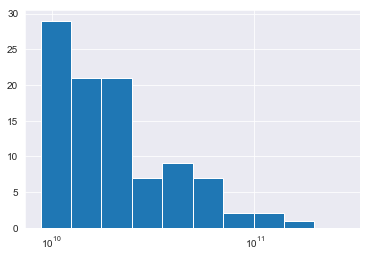

In [11]:
plot_loghist(etf_tickers.AUM, 10)

In [12]:
# Transform dataframe to calculate ETF statistics

mydf =etf_df.pivot_table(values='Adj Close', index=['Date'],
                   columns=['ticker']).reset_index()
mydf = mydf.dropna(axis=0).set_index('Date')

mydf.index[0] + timedelta(365*6)
#daily_returns(mydf)
mydf.head()

ticker,ACWI,AGG,AMLP,BIL,BIV,BND,BNDX,BSV,DIA,DVY,...,VXUS,VYM,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-18,46.075481,92.816338,12.366563,88.443031,70.538643,69.637604,44.235397,73.294235,135.647247,55.397823,...,40.860691,49.431366,70.057281,11.441667,39.854500,28.917545,35.445660,32.013935,45.548874,54.773849
2013-07-19,46.101791,93.058708,12.373424,88.443031,70.808197,69.818207,44.075134,73.339890,135.634964,55.496544,...,40.835247,49.489983,71.033028,11.447189,40.262356,28.429413,35.650356,32.022064,46.151199,54.727905
2013-07-22,46.268414,93.179863,12.421464,88.443031,70.850342,69.861206,44.208679,73.330772,135.626190,55.545925,...,41.072754,49.565361,70.803909,11.524499,40.288956,28.510767,35.573601,31.989550,46.379349,54.691158
2013-07-23,46.321033,93.127922,12.366563,88.443031,70.816620,69.844002,44.288822,73.330772,135.844833,55.545925,...,41.259373,49.590488,70.922691,11.480321,40.262356,28.393251,35.505367,32.070835,46.215080,54.617668
2013-07-24,46.136875,92.825050,12.318522,88.462379,70.471275,69.620415,44.181965,73.212090,135.617523,55.118080,...,41.089718,49.330856,70.133659,11.397493,39.952034,28.583086,35.275093,31.583071,46.142071,54.433918


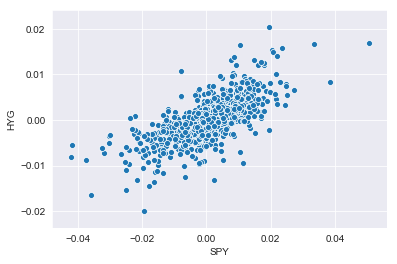

In [28]:
# Identify top 10 and bottom 10 performers
sns.scatterplot(x='SPY', y='HYG', data=etf_daily)

In [14]:
etf_cum = cum_return(mydf)

bottom_10 = list(etf_cum.iloc[-1].nsmallest(10).index)
bottom_10.reverse()
top_10 = list(etf_cum.iloc[-1].nlargest(10).index)

# Plot top 10 and bottom 10
top_bottom = etf_cum[top_10 + bottom_10]
n_tickers = etf_tickers[etf_tickers['Symbol'].isin(top_10+bottom_10)]
n_tickers.set_index('Symbol', inplace=True)
n_tickers = n_tickers.join(top_bottom.iloc[-1], )
#top_bottom.iloc[-1]
n_tickers.columns = n_tickers.columns.tolist()[:-1] + ['cum_return']
n_tickers.sort_values('cum_return', ascending=False)

,Name,AUM,Avg Volume,cum_return
Symbol,,,,
VGT,Vanguard Information Technology ETF,21557917970,"613,750",2.925227
FDN,First Trust Dow Jones Internet Index,9177427870,"415,830",2.920796
XLK,Technology Select Sector SPDR Fund,22322560250,"12,649,847",2.698708
QQQ,Invesco QQQ,76501997970,"32,553,898",2.641505
XLF,Financial Select Sector SPDR Fund,25545345180,"43,653,383",2.412236
MTUM,iShares Edge MSCI USA Momentum Factor ETF,10352258560,"955,069",2.362234
IWF,iShares Russell 1000 Growth ETF,46579635150,"1,510,542",2.227833
IVW,iShares S&P 500 Growth ETF,24116342270,"453,900",2.208187
XLY,Consumer Discretionary Select Sector SPDR Fund,14564046720,"3,975,405",2.176221


#### As seen from the results above, the top performers are invested in Technology, Finiaciasls, while the low performers are invested in Bonds and Gold and Energy

1.9535781687732985

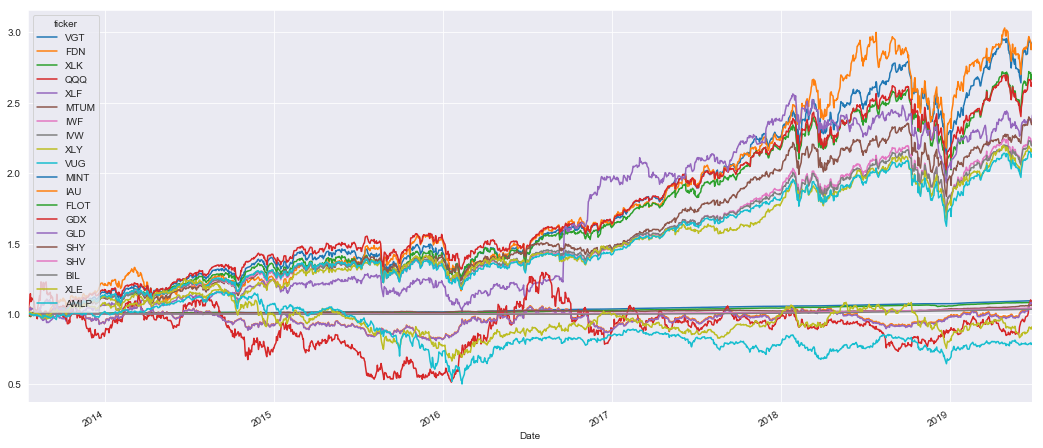

In [15]:
fig, ax = plt.subplots(figsize=(18,8))

top_bottom.plot(kind='line', ax=ax)
etf_cum.iloc[-1]['SPY']

In [16]:
etf_daily = daily_returns(mydf)
etf_std = (etf_daily.std()*np.sqrt(252)).rename('std')
etf_stats = etf_tickers.set_index('Symbol').join(etf_std)
etf_stats.head()

,Name,AUM,Avg Volume,std
Symbol,,,,
SPY,SPDR S&P 500 ETF,279477625560,"67,461,109",0.129093
IVV,iShares Core S&P 500 ETF,184887090640,"3,598,722",0.129310
VTI,Vanguard Total Stock Market ETF,120845792970,"2,472,492",0.130060
VOO,Vanguard S&P 500 ETF,120178358580,"2,696,516",0.129338
QQQ,Invesco QQQ,76501997970,"32,553,898",0.164056


In [17]:
etf_stats.nlargest(5, 'std')
etf_stats.nsmallest(10, 'std')

,Name,AUM,Avg Volume,std
Symbol,,,,
SHV,iShares Short Treasury Bond ETF,24559745120,"2,226,884",0.002104
BIL,SPDR Barclays 1-3 Month T-Bill ETF,9139081290,"1,825,197",0.002606
MINT,PIMCO Enhanced Short Maturity Strategy Fund,11925333720,"891,411",0.004462
FLOT,iShares Floating Rate Bond ETF,9826610510,"1,419,194",0.007732
SHY,iShares 1-3 Year Treasury Bond ETF,16735180080,"2,935,353",0.008903
IGSB,iShares Short-Term Corporate Bond ETF,12707098360,"1,634,795",0.010300
BSV,Vanguard Short-Term Bond ETF,22466511290,"1,373,827",0.013861
VCSH,Vanguard Short-Term Corporate Bond ETF,24098317690,"1,627,683",0.015482
VMBS,Vanguard Mortgage-Backed Securities ETF,10022629040,"911,542",0.025978


In [18]:
#((etf_daily+1).prod(axis=0))['QQQ']
#1.000684*1.003829
#1.004223*1.003773
#1.000571 1.003184
#print(1.000571*1.002611)
#etf_daily
#(gmean(etf_daily+1, axis=0))
mydf.corr()['SPY'].nsmallest(15)
#etf_daily[['SPY', 'TLT']].plot(x='SPY', y='TLT', kind='scatter')


ticker
AMLP   -0.569972
XLE    -0.179876
GDX     0.006051
GLD     0.048599
IAU     0.094119
EWZ     0.277858
IEF     0.631033
TLT     0.650746
GOVT    0.683117
EEM     0.695427
VWO     0.720835
VGK     0.730844
IEMG    0.737594
BIL     0.790381
BIV     0.797075
Name: SPY, dtype: float64

[4. 2.]


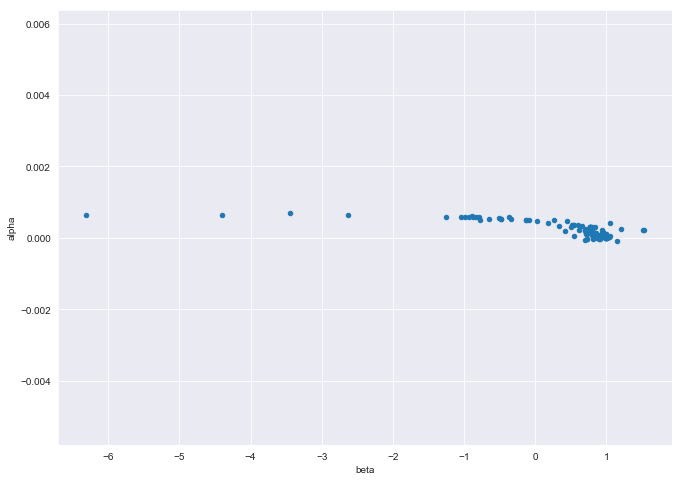

In [22]:
x = np.array(list(range(1,11)))
y = x*4 + 2
print(np.polyfit(x,y, 1))
#model = LinearRegression()
#model.fit(x.reshape(-1,1),y)
#model.coef_
#model.intercept_
def get_coeff(x,y):
    return np.polyfit(x,y, 1)
def alpha_beta(df):
    df.apply(get_coeff, axis=0, args=(SPY))
#np.polyfit(x,y, 1)
cols = mydf.columns.tolist()
cols.remove('SPY')

alpha_beta = etf_daily[cols].apply(get_coeff, axis=0,  y=(etf_daily['SPY'].values))
alpha_beta.index = ['beta', 'alpha']
#mydf['SPY']
fig,ax = plt.subplots(figsize=(11,8))
#plt.xlim(0,1.3)
alpha_beta.transpose().plot(x='beta', y='alpha', kind='scatter', ax=ax)
px.scatter(alpha_beta.transpose().reset_index(), x='beta', y='alpha', symbol='ticker')

In [24]:
alpha_beta['XLU']['alpha']

beta     0.329593
alpha    0.000330
Name: XLU, dtype: float64

In [19]:
1. Select top 10 performers and bottom 10 performs
2. Select top 10 volatile ETF and least volatile
3. get annualized return and annualized standard deviation
4. plot against each other, 
5  Perform clustering of 5 groups

SyntaxError: invalid syntax (<ipython-input-19-435697d2e152>, line 1)

In [ ]:
daily_returns(mydf)
mydf.std()
ans = (mydf.div(mydf.iloc[0].values, axis=1)) - 1

fig, ax = plt.subplots(figsize=(11,6), dpi=100)
ax = sns.scatterplot(mydf.std(),ans.iloc[-1])
ax.set_xlabel('volatility')
ax.set_ylabel('Return')

plot_df = pd.DataFrame({'mean_returns': ans.iloc[-1], 'std': mydf.std()})
plot_df.reset_index(inplace=True)
#px.scatter(plot_df, 'std', 'mean_returns', symbol='ticker')


In [21]:
#etf_df.groupby('ticker')['Date'].min().astype('datetime64[M]').sort_values()#.astype(str).values
#date(2013, 7, 18)+timedelta(365*5)
#df = etf_df[['Date']]
#df.groupby([df["Date"].dt.year, df["Date"].dt.month]).count().plot(kind="bar")
dttt = Fetcher(r'^GSPC', [2019,7,1])

In [22]:
dttt.getHistorical()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-07-01,2971.409912,2977.929932,2952.219971,2964.330078,2964.330078,3513270000
1,2019-07-02,2964.659912,2973.209961,2955.919922,2973.010010,2973.010010,3206840000
2,2019-07-03,2978.080078,2995.840088,2977.959961,2995.820068,2995.820068,1963720000
3,2019-07-05,2984.250000,2994.030029,2967.969971,2990.409912,2990.409912,2434210000
4,2019-07-08,2979.770020,2980.760010,2970.090088,2975.949951,2975.949951,2904550000
5,2019-07-09,2965.520020,2981.899902,2963.439941,2979.629883,2979.629883,3028210000
6,2019-07-10,2989.300049,3002.979980,2984.620117,2993.070068,2993.070068,3154240000
7,2019-07-11,2999.620117,3002.330078,2988.800049,2999.909912,2999.909912,3154620000
8,2019-07-12,3003.360107,3013.919922,3001.870117,3013.770020,3013.770020,2974960000
9,2019-07-15,3017.800049,3017.800049,3008.770020,3014.300049,3014.300049,2874970000
